In this notebook we provide a small example of our methodology to use deep learning in real time to accelerate GMRES

We demonstrate our real-time deep-learning methodology using the $2D$ Poisson problem. 


In particular, we solve a sequence of problems

\begin{align}
\Delta u = f_i \\
u |_{ \partial \Omega} = 0
\end{align} 
where $f_i$ are randomly permuted for every index. 







The gist of our idea is that our real-time deep learning methodology wraps around a provided GMRES solver, and over time
learns an initial guess/left perconditioner that accelerates the rate of convergence of the solver.

First, we set a number of things such as:
- Dimension of $N \times N$ grid
- Default initial guess for GMRES iterations
- Tolerance for GMRES solver
- Restarted GMRES restart parameters
- Total number of "time steps"

In [28]:
from src_dir import mk_laplace_2d,mk_laplace_2d_Tensor
import numpy as np

# Set dimension of the NxN grid used
# Note: # A network consistent with dimension must manually be selected in the "cnn_collectionOnline2D.py"
dim=20



# Default initial guess used for direct 
# un-preconditioned GMRES is the zero solution
x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'


# Set tolerances for GMRES solver
e = 1e-5


# Restarted GMRES parameters
nmax_iter = 100
restart   = 10000


# Create domain [-1,1]x[-1,1]
# Define grid values at midpoints of cartesian grid
DomainL=-1.0
DomainR=1.0
dx=(DomainR-DomainL)/(dim-1)
x1=np.linspace(DomainL+dx,DomainR-dx,dim)
x2=np.linspace(DomainL+dx,DomainR-dx,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')
Area=(dx*(dim-1))**2

# Create 2D laplace opertor as
# a stencil opertor for a N-cell 2D grid
# Can be found in linop.py in src_di
A=mk_laplace_2d(dim,dim,bc="dirichlet", xlo=0, xhi=0, ylo=0, yhi=0)
AType='2D Laplacian'


# Total number of steps in simulation
n_steps =2000

A sample of the RHS used in the demo is shown below:

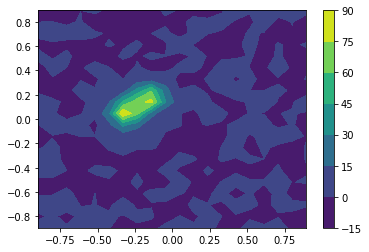

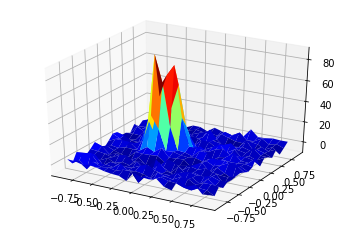

In [33]:
# A sample of the RHS used in the demo
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D  
from src_dir import Gauss_pdf_2D

# Compute dipole
xloc=np.random.uniform(x1[0],x1[-1])
yloc=np.random.uniform(x2[0],x2[-1])
xlocShift=np.random.uniform(-0.25,0.25)
ylocShift=np.random.uniform(-0.25,0.25)
AmplitudeFactor= np.random.uniform(1,10)
AmplitudeFactor2= AmplitudeFactor*np.random.uniform(1,2)
sigma=0.07*np.random.uniform(0.9,1.1)
b=AmplitudeFactor*Gauss_pdf_2D(X,Y,xloc,yloc,sigma)+AmplitudeFactor2*Gauss_pdf_2D(X,Y,xloc+xlocShift,yloc+ylocShift,sigma)

# Compute random field
Field=np.random.normal(loc=0.0, scale=1.0, size=(dim,dim))
Field= AmplitudeFactor*np.random.normal(loc=0.0, scale=1.0, size=(20,20))

b=b+Field




pp.contourf(X,Y,b)
pp.colorbar()

fig = pp.figure()
ax = pp.axes(projection='3d')
ax.plot_surface(X, Y, b, cmap=pp.cm.jet, rstride=1, cstride=1, linewidth=0)

Below, we wrap the simple unprecondition GMRES algorithm implemented in `gmres.py` using a wrapper
that implements our deep learning methodology. This wrapper contains both the neural network we
implemented, the training loop of this network, and additional data curration steps to work online

The neural network can be found in `cnn_collectionOnline2D.py`, and the wrapper can be found in 
`cnn_predictorOnline2D.py`. Stay tuned for a paper the describes our methodology in detail.

In [17]:
from src_dir import cnn_preconditionerOnline_timed_2D,timer,GMRES

# Note: # Model dimention inputs are not used for the current network in cnn_predictorOnline2D.py (but must be passed into wrapper)
InputDim=dim
OutputDim=dim
# Number of samples to collect before using preduction from Neural Network:
Initial_set=32


# Note: he CNN in cnn_predictorOnline2D.py should be adjusted depending on the grid resolution. Some examples are commented out in that file. 
@timer
@cnn_preconditionerOnline_timed_2D(nmax_iter,restart,Area,dx,retrain_freq=1,debug=True,InputDim=InputDim,OutputDim=OutputDim,Initial_set=Initial_set)
def MLGMRES(A, b ,x0, e,ML_GMRES_Time_list,ProbCount,debug,blist,reslist,Err_list,reslist_flat,IterErrList):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

To demonstrate the performance of our approach on a series of poisson problems, we compare the wall clock time between the ML-wrapper GMRES implementation and the direct GMRES implementation.  The loop below (that loops for the number of steps set above) essentially has the following structure:

1. Generate RHS
2. Compute GMRES assisted by neural network (MLGMRES) up to tolreance $e$ and collected data.
3. Compute direct GMRES up to $e$
4. Write error metrics (such as time to solution and error at certain GMRES iterations) and go to 1.


Scroll past the outputs to see some plots

In [4]:
from src_dir import Gauss_pdf_2D,resid


#Set the numpy seed
np.random.seed(0)

# Initialize lists that hold time data (time-to-solutuin, trainining time, MLGMRES time, etc)
ML_GMRES_Time_list=[]
run_time_ML_list=[]
GmresRunTimeOriginal=[]
SpeedUp=[]
trainTime_list=[]


# Set debug mode)prints more information to screen)
debug=True


# initalize lists that will hold all RHS and reisudals
Err_list=[]
NonML_Err_List=[]
blist=[]
reslist=[]
reslist_flat=[]
IterErrList=[]
NonML_Err_List_Full=[]

# Index of  Poisson problems solved
for ProbIdx in range(n_steps):

    # Set RHS of Poisson problem
    xloc=np.random.uniform(x1[0],x1[-1])
    yloc=np.random.uniform(x2[0],x2[-1])
    xlocShift=np.random.uniform(-0.25,0.25)
    ylocShift=np.random.uniform(-0.25,0.25)
    AmplitudeFactor= np.random.uniform(0.01,10)
    AmplitudeFactor2= AmplitudeFactor*np.random.uniform(1,2)
    sigma=0.07*np.random.uniform(0.9,1.1)
    b=AmplitudeFactor*Gauss_pdf_2D(X,Y,xloc,yloc,sigma)+AmplitudeFactor2*Gauss_pdf_2D(X,Y,xloc+xlocShift,yloc+ylocShift,sigma)
    Field=np.random.normal(loc=0.0, scale=1.0, size=(dim,dim))
    Field= AmplitudeFactor*np.random.normal(loc=0.0, scale=1.0, size=(20,20))
    b=b+Field

    # b=np.maximum(xloc*2*X*np.sin(ProbIdx),yloc*2*Y*np.cos(ProbIdx))  # Linear gradient example
    b=b*(dx**2.0) # Finite difference grid spacing




    # First GMRES call (solve up to e1 tolerance) with ML wrapper
    OutList1,run_time1_ML=MLGMRES(A, b, x0, e, ML_GMRES_Time_list,ProbIdx,debug,blist,reslist,Err_list,reslist_flat,IterErrList)  
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    trainTime_list.append(OutList1[2])
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]
    reslist_flat=OutList1[6]
    IterErrList=OutList1[7]

    # Collect ML assisted Run-times
    run_time_ML_list.append(run_time1_ML)
    


    # Direct GMRES call up to e1 tolerance
    NonML_Out1,run_time1=GMRES_timed(A, b, x0, e, nmax_iter,restart, debug)  
    NonML_Err=resid(A, NonML_Out1, b)
    NonML_Err_List_Full.append(NonML_Err)
    NonML_Err_List.append(NonML_Err[22])

    ## Collect  direct GMRES time
    GmresRunTimeOriginal.append(run_time1)

    ## Ratio of run-times
    SpeedUp.append(run_time1/ML_GMRES_Time_list[-1])
    

    print("Current 'Time-step':",ProbIdx)
    print("Speed up:", SpeedUp[-1])
    print("**********")

MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list)
run_time=sum(GmresRunTimeOriginal)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


print("Runtime of Non-decorated version is:",run_time)

print("Runtime of MLGMRES decorator is:",run_time_ML)

print("Runtime of MLGMRES (only GMRES time) is:",MLGMRES_GMRES_ONLY)

print("Runtime of training (backprop) is:",trainTime_total)

*************
Total Loss: 1.3589863556262571e-05
****************
****************
Total Loss: 1.1754525075957645e-05
****************
****************
Total Loss: 1.0996827768394724e-05
****************
****************
Total Loss: 1.5292464013327844e-05
****************
****************
Total Loss: 1.1086131053161807e-05
****************
****************
Total Loss: 1.1522178283485118e-05
****************
****************
Total Loss: 1.537489879410714e-05
****************
****************
Total Loss: 1.489012902311515e-05
****************
****************
Total Loss: 1.3825410860590637e-05
****************
****************
Total Loss: 1.0661827218427788e-05
****************
****************
Total Loss: 1.3966168808110524e-05
****************
****************
Total Loss: 1.402187717758352e-05
****************
****************
Total Loss: 1.0067962648463435e-05
****************
****************
Total Loss: 1.583806806593202e-05
****************
****************
Total Loss: 1.2693021744

Below, the error for the 5th GMRES iteration for every "time-step"  is plotted. The gist is that we see neural network is learning to produce initial guesses that improve the error at this iteration as our simulation progresses.  

In [5]:
import matplotlib.pyplot as pp
from src_dir import moving_average



# Compute moving average of GMRES and MLGMRES error
AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)

Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)
for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))
for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)    


# Compute moving average of GMRES and MLGMRES run-times
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)

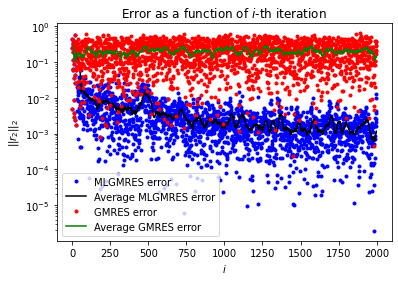

In [6]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration')
pp.legend(loc='best')
pp.yscale("log")

Below, the time-to-solution for every "time-step"  is plotted.
Here, we see the neural network is learning to produce initial guesses that improve the overall time-to-solution for every iteration as our simulation progresses.  

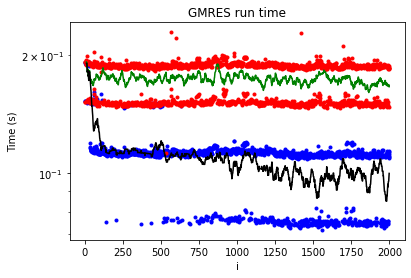

In [7]:
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('GMRES run time')
# pp.legend(loc='best')
# pp.ylim(0.025,0.15)
pp.yscale("log")

In the figure below, the GMRES iterations for a single linear problem is plotted. This figures is particularly useful for understanding why we are getting a speed-up at all. In a nut-shell, we get a speed up because the NN-provided intial guess temporarily improves the rate of convergence of GMRES

Text(0.5, 1.0, 'Convergence of Algorithim for Final Linear Problem')

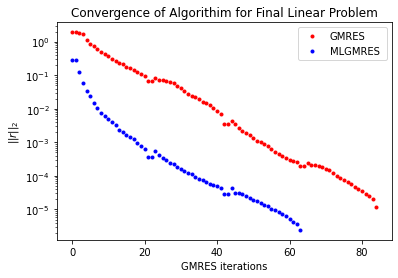

In [14]:
RHSIndex=-600
pp.semilogy(NonML_Err_List_Full[RHSIndex],'.r',label='GMRES')
pp.semilogy(IterErrList[RHSIndex],'.b',label='MLGMRES ')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem')

The ratio of GMRES/MLGMRES time-to-solutions are plotted below for the first $e_1$ tolerance. 
It should be noted that our methodology wraps around the direct GMRES solver,
so the exact same solver is used in both approaches, and only differ by what initial condition
(or effectively left-preconditioner) is applied. 

Text(0.5, 1.0, 'NN Speed Up ')

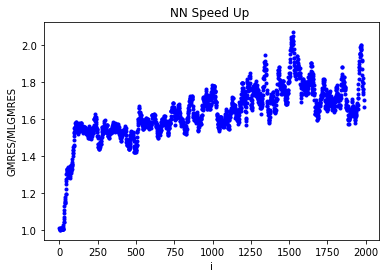

In [9]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-1]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-1]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)

pp.plot(Ratio,'.b')
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("NN Speed Up ")